In [1]:
from __future__ import division, print_function
from functools import partial, reduce
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore
import fitpack
import interface
import obslib.sidis.reader
from qcdlib.auxiliary import AUX
from tools.config import conf
%matplotlib notebook 

In [2]:
def get_data():
    # Merge all of the data tables
    return reduce(partial(pd.DataFrame.merge, how="outer"), map(pd.DataFrame, conf["sidis tabs"].values()))

In [3]:
plt_label = {
    "Q2": "$Q^2$",
    "qT": "$q_T$",
    "qT": "$q_T$",
    "W2": "$W^2\; (GeV^2)$",
    "qToverQ": "$q_T/Q$",
    "qToverQ2": "$q_T^2/Q^2$",
    "dy": "$y_p-y_h$",
    "yh_minus_yp": "$y_h-y_p$",
    "yi": "$y_i$",
    "yf": "$y_f$",
    "yh": "$y_h$",
    "yp": "$y_p$",
    "yi_minus_yp": "$|y_i - y_p|$",
    "yf_minus_yh": "$|y_f - y_h|$",
    "yi_minus_yp_over_yp": "$|(y_i - y_p)/yp|$",
    "yf_minus_yh_over_yh": "$|(y_f - y_h)/yh|$",
    "R": "$|R|$",
    "lnR": "$ln(|R|)$",
    "R2": "$R_2$",
    "R1": "$R_1$",
    "R0": "$R_0$"
}


def color_plot3D(data,x_lab, y_lab, z_lab, colors=None, cmap="plasma", **kwargs):
    xval = data[x_lab].values
    yval = data[y_lab].values
    zval = data[z_lab].values

    if colors is None:
        colors = np.ones(len(xval))  # XXX
    
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.scatter(xval, yval, zval, c=colors, cmap=plt.get_cmap(cmap), **kwargs)

    ax.set_xlabel(plt_label[x_lab])
    ax.set_ylabel(plt_label[y_lab])
    ax.set_zlabel(plt_label[z_lab])

    fig.tight_layout()
    
    return fig, ax

In [4]:
def geo_mean(*xs):
    return np.power(reduce(np.multiply, xs, 1), 1 / len(xs))

upol_hermes_no_filters.py defines data files to read, no filters applied yet to the data selection. Here we read all HERMES multiplicities.

In [5]:
input_file = "../inputs/upol_hermes_no_filters.py"

In [6]:
interface.gen_config(input_file)  # read file

conf["datasets"]["sidis"]["filters"][0] = "index == index"  # workaround for filter req

conf["aux"] = AUX()
conf["sidis tabs"] = obslib.sidis.reader.READER().load_data_sets("sidis")
# conf['sidis stfuncs'] = obslib.sidis.stfuncs.STFUNCS()

data = get_data().sort_values("R0")

loading sidis data sets 1007

In [7]:
print(", ".join(sorted(data.columns)))

Ebeam, F2, Q2, R, R0, R1, R2, W2, col, dy, hadron, i, lnR, obs, pT, qT, stat_u, systabs_u, systole, systrel, target, value, x, xn, y, yf, yh, yi, yp, z, zn


In [8]:
print("points:", len(data))
print("R0 min, max: %f, %f" % (min(data["R0"]), max(data["R0"])))
print("R1 min, max: %f, %f" % (min(data["R1"]), max(data["R1"])))
print("R2 min, max: %f, %f" % (min(data["R2"]), max(data["R2"])))

points: 2660
R0 min, max: 0.009763, 0.072050
R1 min, max: 0.000413, 29634.100191
R2 min, max: 0.033241, 35.983745


In [9]:
R_geo = geo_mean(data["R0"], data["R1"], data["R2"])  # geometric mean of R0, R1, R2

color_percentiles = partial(percentileofscore, R_geo)
data["gmean%"] = R_geo.apply(color_percentiles) / 100  # percentiles of geometric means

d = data[data["gmean%"] <= 0.5]  # to see data bounds

print("points:", len(d))
print("R0 min, max: %f, %f" % (min(d["R0"]), max(d["R0"])))
print("R1 min, max: %f, %f" % (min(d["R1"]), max(d["R1"])))
print("R2 min, max: %f, %f" % (min(d["R2"]), max(d["R2"])))

points: 1330
R0 min, max: 0.009763, 0.072050
R1 min, max: 0.000413, 3.309077
R2 min, max: 0.033241, 2.989749


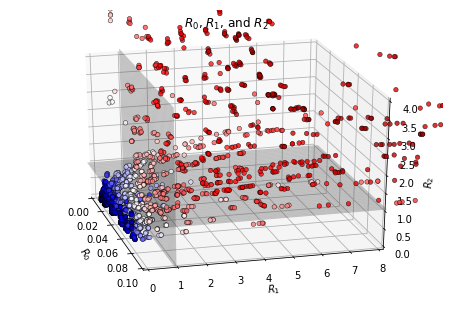

In [10]:
fig, ax = color_plot3D(data, "R0", "R1", "R2",
                       colors=data["gmean%"], cmap="seismic", alpha=0.8,
                       linewidths=0.5, edgecolors="black")

xlims = (0.0, 0.10)
ylims = (0.0, 8.0)
zlims = (0.0, 4.0)

xs = np.linspace(*xlims, num=100)
ys = np.linspace(*ylims, num=100)
zs = np.linspace(*zlims, num=100)

#xs = np.linspace(-1, 1, num=100)
ys = np.linspace(-0.3, 8.3, num=100)
zs = np.linspace(-0.2, 4.2, num=100)

X, Y = np.meshgrid(xs, ys)
Z = np.ones_like(X)
ax.plot_surface(X, Y, Z, alpha=0.3, color="gray")  # plane at z = 1

X, Z = np.meshgrid(xs, zs)
Y = np.ones_like(X)
ax.plot_surface(X, Y, Z, alpha=0.3, color="gray")  # plane at y = 1

Y, Z = np.meshgrid(ys, zs)
X = np.ones_like(Y)
#ax.plot_surface(X, Y, Z, alpha=1.0, color="gray")

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_zlim(zlims)

ax.view_init(25, -15)

ax.set_title("$R_0$, $R_1$, and $R_2$")

fig.tight_layout()

fig.savefig("../Figs/hermes-3d-R.pdf")

fig.show()

The color of each point in the figure shown above is determined by the geometric mean of its R_0, R_1, and R_2 values.

The coloring is based on the percentile of the geometric mean within the dataset.

The lower the geometric mean, the bluer the point.
The higher the geometric mean, the redder the point.
Points neither blue nor red tend towards the median geometric mean.